In [1]:
# Importando análise
import numpy as np
import pandas as pd
from scipy import special
from random import sample

In [2]:
# Primeiro recarregamos o dataset
X = pd.read_csv("X.csv", header=0)
X.head()

,media_id,tempo,pais_Afghanistan,pais_Albania,pais_Algeria,pais_Angola,pais_Antigua and Barbuda,pais_Argentina,pais_Armenia,pais_Australia,...,pais_United States,pais_Uruguay,pais_Uzbekistan,pais_Vanuatu,pais_Venezuela,pais_Viet Nam,pais_Virgin Islands (U.S.),pais_Yemen,pais_Zambia,pais_Zimbabwe
0,0.000000,0.421773,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.000000,0.435753,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0.578947,0.000000,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0.000000,0.540331,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.000000,0.496019,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [5]:
Y = pd.read_csv("Y.csv", header=-1)
# Transformando em array
Y = Y.values

,0
0,0
1,0
2,1
3,0
4,0


In [7]:
# Importando modelos
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.metrics import f1_score

In [12]:
# Dividindo os dados
X_dev, X_eval, Y_dev, Y_eval = train_test_split(X, Y, train_size=.75, random_state=23)
# Adicione o vetor de destino de volta ao conjunto de recursos
X["fraude"] = Y

# Separe as anomalias das normais
X_anomalies = X[ X["fraude"] == 1 ]
X_normals = X[ X["fraude"] == 0 ]

# Amostra aleatória de 70% dos índices do conjunto de dados normal para treinamento
train_idxs = sample(list(X_normals.index), int(0.7 * X_normals.shape[0]))
X_train = X_normals.loc[train_idxs]

# Guarde o resto para o conjunto de testes
X_testing = X_normals.drop(train_idxs)

# O conjunto de testes deve agora ser a combinação das instâncias normais restantes que não estão no conjunto de treinamento
# e as instâncias de anomalia
X_testing = pd.concat([X_testing, X_anomalies], axis=0)

# Embaralhe as linhas para ambos os conjuntos de dados
X_train = X_train.sample(frac=1).reset_index(drop=True)
X_testing = X_testing.sample(frac=1).reset_index(drop=True)

#Divida o dataframe de teste em conjuntos de dados de validação cruzada e de avaliação
Y_testing = X_testing["fraude"]
X_testing = X_testing[ [col for col in X_testing.columns if col != "fraude"] ]
X_cv, X_eval, Y_cv, Y_eval = train_test_split(X_testing, Y_testing, train_size=.7, random_state=23)

# Mapeie os valores Y_cv e Y_val para a convenção 1 (normal), -1 (anomalias)
Y_cv = Y_cv.apply(lambda x: 1 if x == 0 else -1)
Y_eval = Y_eval.apply(lambda x: 1 if x == 0 else -1)

# Finalmente, exclua a coluna de classe do conjunto de treinamento
X_train = X_train[ [col for col in X_testing.columns if col != "fraude"] ]

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

          -1       0.00      0.00      0.00      4221
           0       0.00      0.00      0.00         0
           1       0.03      0.01      0.01     12351

   micro avg       0.01      0.01      0.01     16572
   macro avg       0.01      0.00      0.00     16572
weighted avg       0.02      0.01      0.01     16572

Área sobre a curva ROC: 0.077


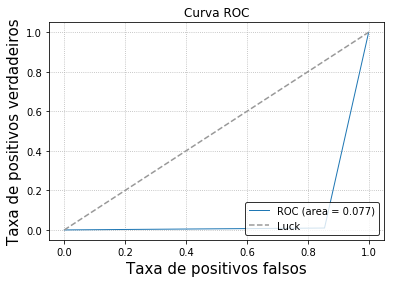

In [14]:
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(random_state=1)
decision_tree.fit(X_dev,Y_dev)

Y_predicted = decision_tree.predict(X_eval)
roc_auc = roc_auc_score(Y_eval, Y_predicted)

cv_preds = decision_tree.predict(X_cv)
print(classification_report(Y_eval, 
                            Y_predicted))
print("Área sobre a curva ROC: {:0.3f}".format(roc_auc))

dt_probs = decision_tree.predict_proba(X_eval)
fpr, tpr, _ = roc_curve(Y_eval, Y_predicted)


plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.3f)'%(roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Taxa de positivos falsos', fontsize=15)
plt.ylabel('Taxa de positivos verdadeiros', fontsize=15)
plt.title('Curva ROC', fontsize=12)
plt.legend(loc="lower right", frameon = True).get_frame().set_edgecolor('black')
plt.grid(True, linestyle = 'dotted')
plt.show()